In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Taxi_data_analysis").getOrCreate()

# Getting the Spark Session ready to read or write file for further analysis

In [2]:
df = spark.read.parquet("yellow_tripdata_2023-01.parquet",header=True,inferSchema=True)

In [6]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

# Performing aggreagate functionality

In [7]:
#Average fare count
df.select("fare_amount").groupBy().avg().show()

+-----------------+
| avg(fare_amount)|
+-----------------+
|18.36706861234247|
+-----------------+



# Extract time-based features (e.g., date, hour)

In [9]:
#Extract time-based features (e.g., date, hour)
from pyspark.sql.functions import to_date, hour, dayofweek, date_format
df_time = df.withColumn("pickup_date", to_date("tpep_pickup_datetime")).withColumn("pickup_hour", hour("tpep_pickup_datetime")).withColumn("pickup_day", dayofweek("tpep_pickup_datetime"))

In [12]:
#df_time.show()
daily_trips = df_time.groupBy("pickup_date").count().orderBy("pickup_date")
daily_trips.show()

+-----------+------+
|pickup_date| count|
+-----------+------+
| 2008-12-31|     2|
| 2022-10-24|     4|
| 2022-10-25|     7|
| 2022-12-31|    25|
| 2023-01-01| 76752|
| 2023-01-02| 65777|
| 2023-01-03| 85783|
| 2023-01-04| 95092|
| 2023-01-05|101063|
| 2023-01-06|102550|
| 2023-01-07|105036|
| 2023-01-08| 85056|
| 2023-01-09| 85349|
| 2023-01-10| 99916|
| 2023-01-11|106118|
| 2023-01-12|111386|
| 2023-01-13|110719|
| 2023-01-14|112950|
| 2023-01-15| 96844|
| 2023-01-16| 80120|
+-----------+------+
only showing top 20 rows



In [46]:
hourly_trips = df_time.groupBy("pickup_hour").count().orderBy("pickup_hour")

# Visualizing data

In [47]:
import pandas as pd

# Converting pySpark Data frame to pandas dataframe for visualizing it with Matplotlib

In [48]:
df_pandas = daily_trips.toPandas()

# Now let's visualize the data and plot a trendline

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [54]:
import datetime

df_pandas["pickup_date"] = pd.to_datetime(df_pandas["pickup_date"])

start_date = pd.to_datetime("2023-01-01")
end_date = pd.to_datetime("2023-02-01")

df_jan = df_pandas[(df_pandas["pickup_date"] >= start_date) & 
                   (df_pandas["pickup_date"] < end_date)]

In [61]:
df_pandas_hourly = hourly_trips.toPandas()

In [64]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
df_jan["pickup_date"] = pd.to_datetime(df_jan["pickup_date"])

# Convert dates to ordinal numbers
x = df_jan["pickup_date"].map(datetime.datetime.toordinal)
y = df_jan["count"]
coeffs = np.polyfit(x, y, deg=1)
trendline = np.poly1d(coeffs)

# Calculate predicted y values for the trendline
y_trend = trendline(x)

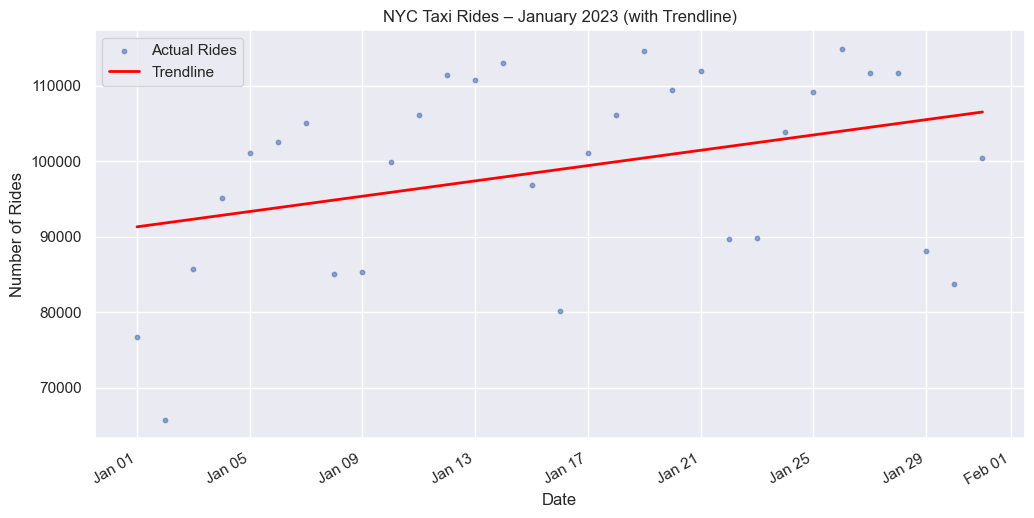

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))

# Scatter plot
plt.scatter(df_jan["pickup_date"], y, s=10, alpha=0.6, label="Actual Rides")

# Trendline
plt.plot(df_jan["pickup_date"], y_trend, color='red', linewidth=2, label="Trendline")

plt.title("NYC Taxi Rides – January 2023 (with Trendline)")
plt.xlabel("Date")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.legend()

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate()

plt.show()

# hourly trend analysed

<Axes: title={'center': 'Hourly Ride Demand'}, xlabel='pickup_hour'>

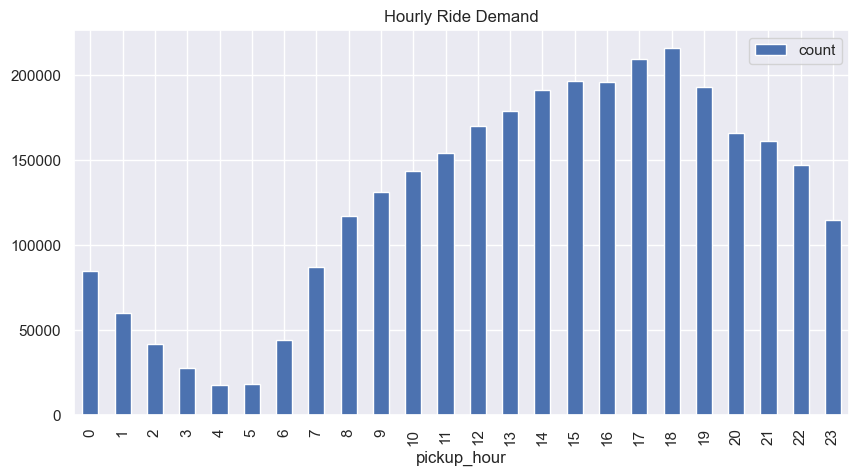

In [66]:
df_pandas_hourly.plot(x="pickup_hour", y="count", kind="bar",figsize=(10,5), title="Hourly Ride Demand")